In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import kagglehub

plt.close('all')

Dataset folder: C:\Users\Lalo\.cache\kagglehub\datasets\thedevastator\airbnb-prices-in-european-cities\versions\3
CSV files found: ['amsterdam_weekdays.csv', 'amsterdam_weekends.csv', 'athens_weekdays.csv', 'athens_weekends.csv', 'barcelona_weekdays.csv', 'barcelona_weekends.csv', 'berlin_weekdays.csv', 'berlin_weekends.csv', 'budapest_weekdays.csv', 'budapest_weekends.csv', 'lisbon_weekdays.csv', 'lisbon_weekends.csv', 'london_weekdays.csv', 'london_weekends.csv', 'paris_weekdays.csv', 'paris_weekends.csv', 'rome_weekdays.csv', 'rome_weekends.csv', 'vienna_weekdays.csv', 'vienna_weekends.csv']

Rows, Cols: (51707, 22)
Price column: realSum
Cities (top 10):
 city
London       9993
Rome         9027
Paris        6688
Lisbon       5763
Athens       5280
Budapest     4022
Vienna       3537
Barcelona    2833
Berlin       2484
Amsterdam    2080
Name: count, dtype: int64


,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,period,source_file
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,weekdays,amsterdam_weekdays.csv
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,weekdays,amsterdam_weekdays.csv
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,weekdays,amsterdam_weekdays.csv
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,weekdays,amsterdam_weekdays.csv
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,weekdays,amsterdam_weekdays.csv


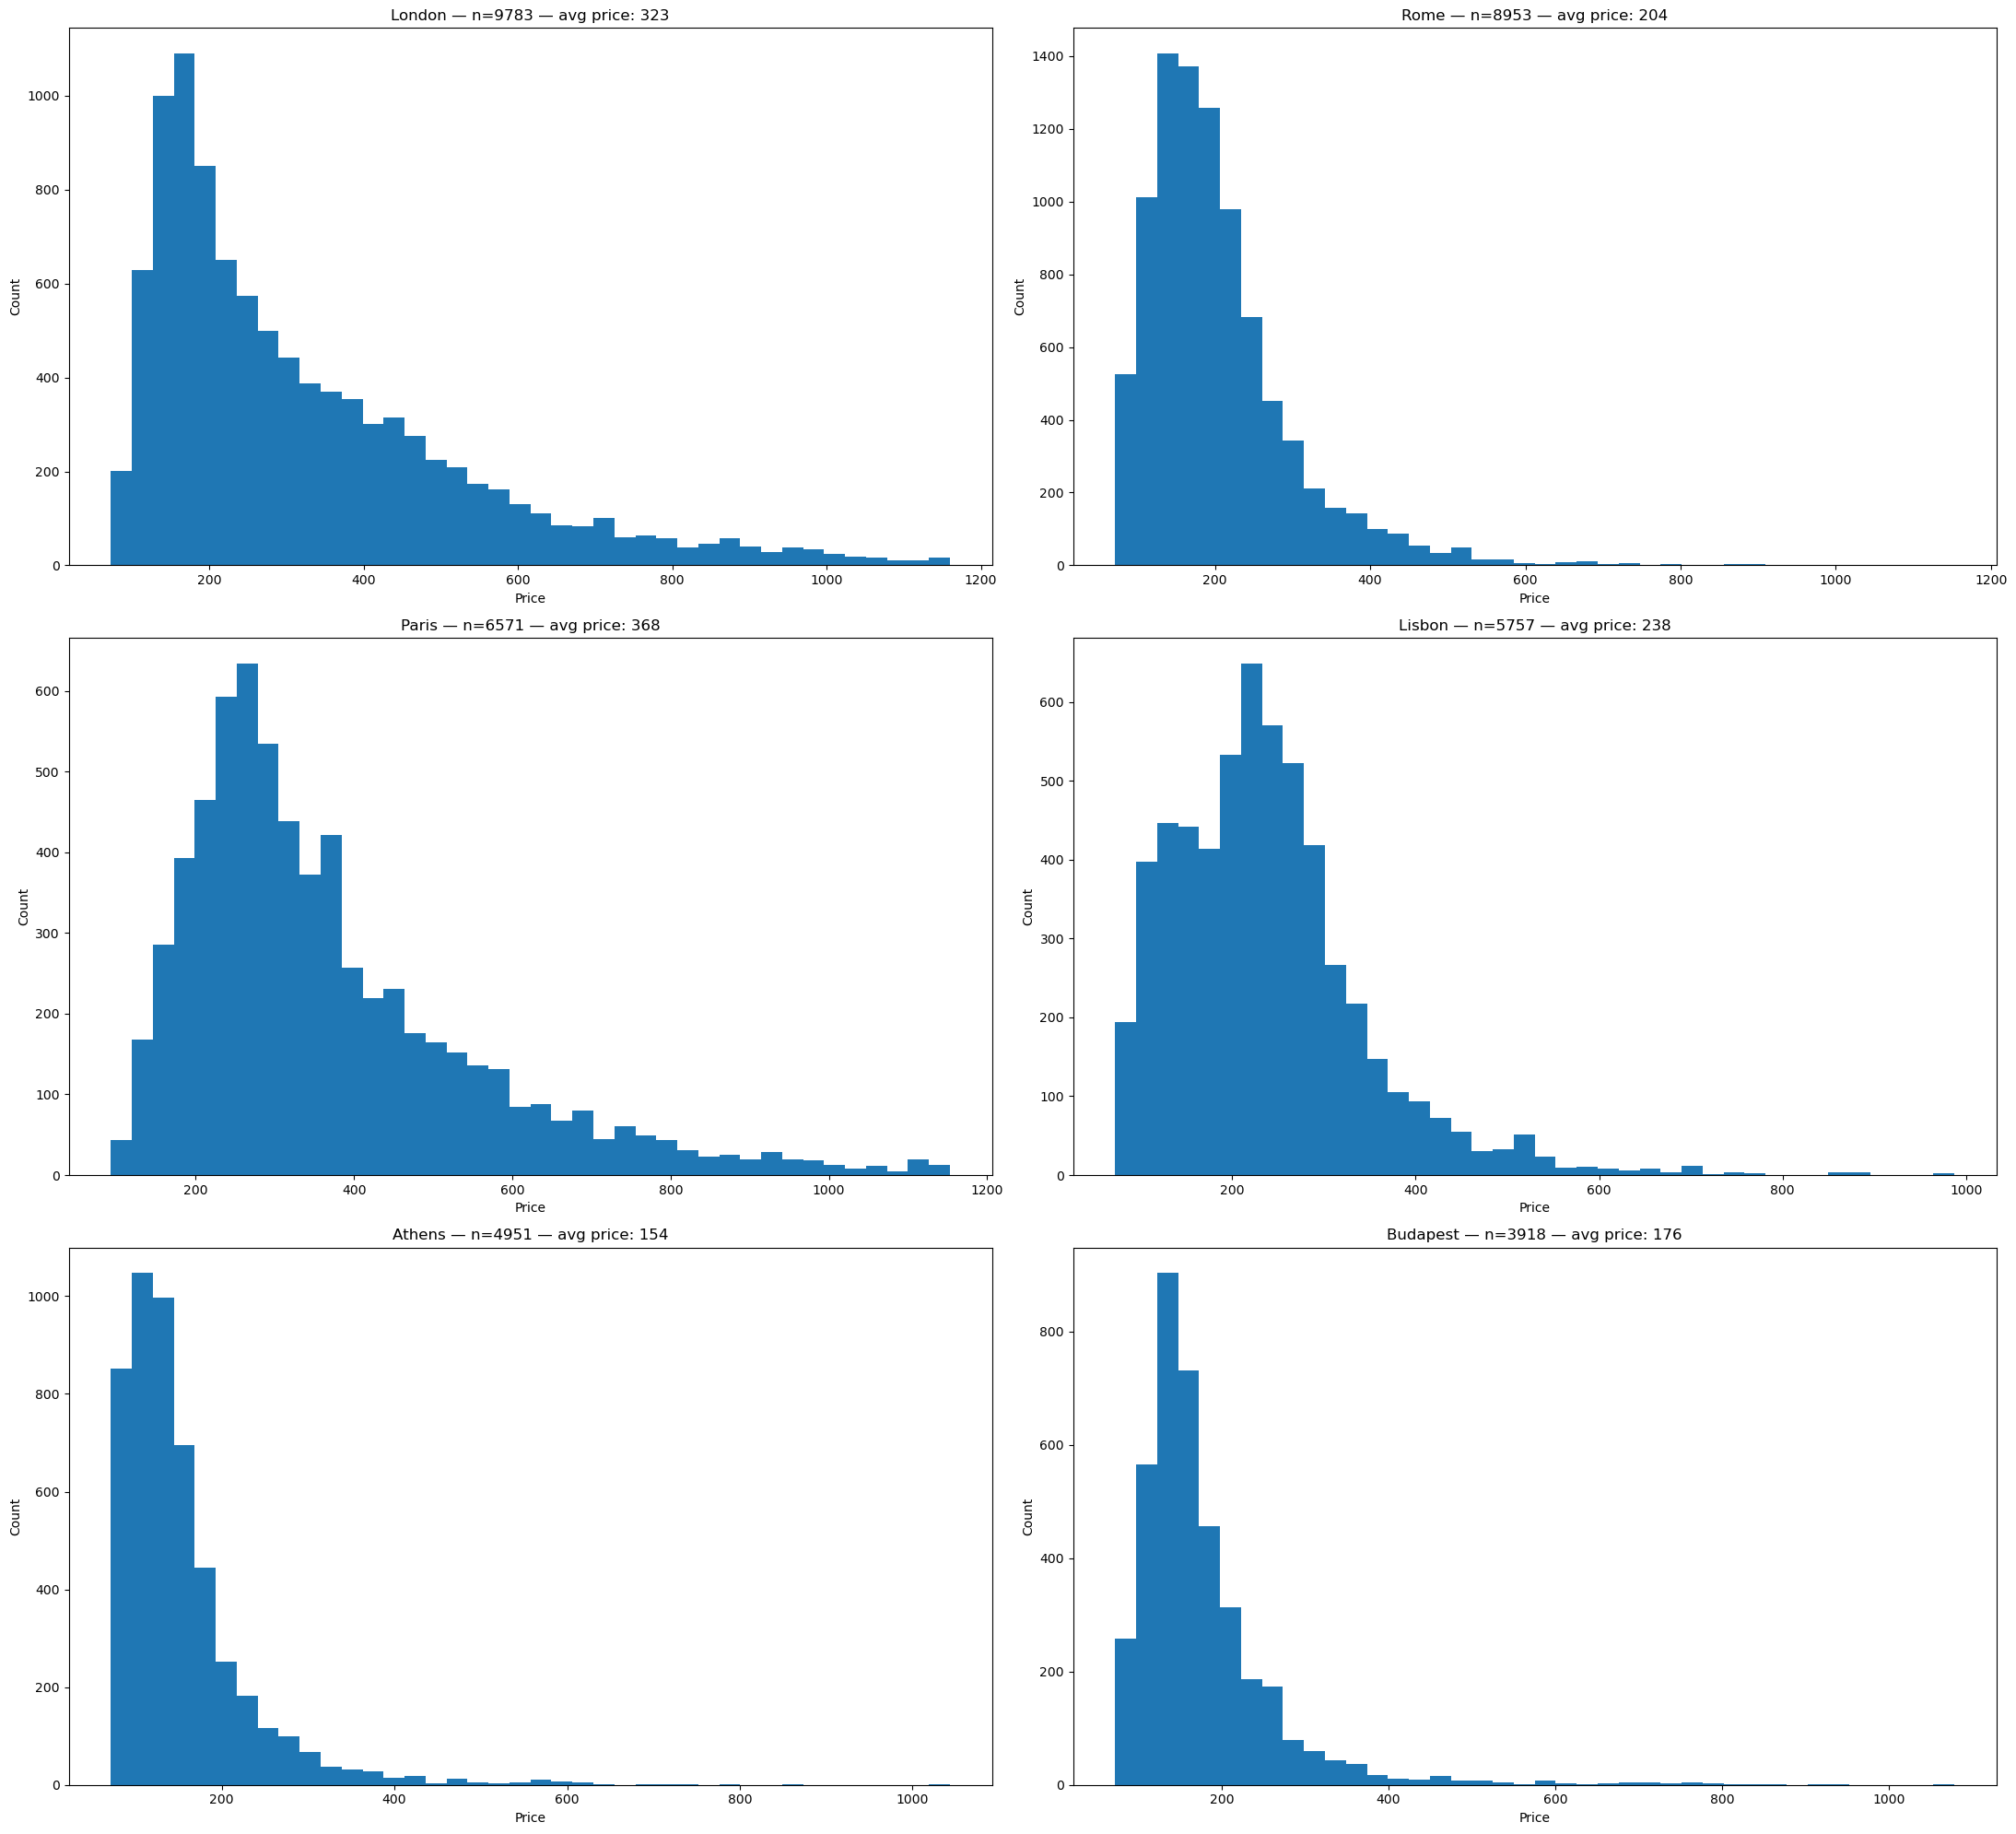

In [5]:
# 1) Download (or reuse cache) and list CSV files
base = Path(kagglehub.dataset_download("thedevastator/airbnb-prices-in-european-cities"))
csv_files = sorted(base.glob("*.csv"))
print("Dataset folder:", base)
print("CSV files found:", [p.name for p in csv_files])
assert csv_files, "No CSV files found in the dataset folder."

# 2) Load ALL CSVs, add 'city' (from filename) and 'period' columns, then concat
frames = []
for p in csv_files:
    df_i = pd.read_csv(p)
    stem = p.stem  # e.g., "vienna_weekdays"
    parts = stem.split("_")
    city = parts[0].title() if parts else "Unknown"
    period = parts[1] if len(parts) > 1 else None
    df_i["city"] = city
    df_i["period"] = period
    df_i["source_file"] = p.name
    frames.append(df_i)

df = pd.concat(frames, ignore_index=True)

# 3) Light cleaning: drop unnamed index col if present; pick a price column
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

price_col = "realSum" if "realSum" in df.columns else ("price" if "price" in df.columns else None)
assert price_col is not None, f"No price column found. Columns: {df.columns.tolist()}"

print("\nRows, Cols:", df.shape)
print("Price column:", price_col)
print("Cities (top 10):\n", df["city"].value_counts().head(10))
display(df.head())

# 4) Plot: price distribution per city (top 6 by count)
s = df[price_col].astype(float).dropna()
low, high = s.quantile([0.01, 0.99])  # trim outliers for nicer plots
clean = df[df[price_col].between(low, high)]

top_cities = clean["city"].value_counts().head(6).index.tolist()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(22, 20))
axes = axes.flatten()

for ax, city in zip(axes, top_cities):
    sub = clean[clean["city"] == city]
    ax.hist(sub[price_col], bins=40)
    ax.set_title(f"{city} — n={len(sub)} — avg price: {sub[price_col].mean():.0f}")
    ax.set_xlabel("Price")
    ax.set_ylabel("Count")

plt.tight_layout()